# From the Tiersten paper

# Piezo electric equations for isotropic homogeneous materials

If we look at equations 1.8a, 1.8b from the paper:

$$
\begin{array}{c}
c^{E}{ }_{1 j k 1} u_{k, 11}+e_{11 j} \varphi_{, 11}=\rho \ddot{u}_{j} \qquad &(1.8a) \\
e_{1 k 1} u_{k, 11}-\epsilon_{11}^{S} \varphi_{, 11}=0 \qquad &(1.8b) \\
\end{array}
$$

We can rewrite this to the easier to read 1D forms, where subscript $1$ is in the $z$-direction (I don't index the constants here):

$$
\begin{array}{c}
c^E \frac{\partial^2 u}{\partial x^2} + e \frac{\partial^2 \phi}{\partial x^2} = \rho \frac{\partial^2 u}{\partial t^2}  \qquad &(2)\\
e \frac{\partial^2 u}{\partial x^2} - \epsilon^s \frac{\partial^2 \phi}{\partial x^2} = 0 &(3)
\end{array}
$$

and we isolate the $\phi$-term from equation (3):

$$
\frac{\partial^2 \phi}{\partial x^2}  = \frac{e}{\epsilon^S} \frac{\partial^2 u}{\partial x^2}
$$

And substitute it into equation (2), we obtain:

$$
\rho \frac{\partial^2 u}{dt^2} = \left[ c^E + \frac{e^2}{\epsilon} \right] \frac{\partial^2 u}{\partial x^2}
$$

Which would then be the differential equation we want to solve.We now substitute $u(x,t) = u(x)e^{-i\omega t}$ and divide by $e^{i\omega t}$ to obtain the stationary modes
$$ \label{eq:hom_piezo_stationary}
\omega^2 u = -\frac{1}{\rho}\left[ c^E + \frac{e^2}{\epsilon} \right] \frac{\partial^2 u}{\partial x^2}
$$

Using the finite difference approximation and the free boundary condition $\frac{\partial u}{\partial x}=0$ equation \eqref{eq:hom_piezo_stationary} can be written as a numerical eigenvalue problem where $u$ is discretized using $N$ points with spacing $h$.

Interestingly, equation \eqref{eq:hom_piezo_stationary} is equivalent to the equation for the stationary modes in the acoustic model, apart from the fact that there is now a modified stiffness coefficient 

$$
c^{'} = c^E + \frac{e^2}{\epsilon^S}
$$

If the boundary condition is $T = 0$, then $\frac{du}{dx}$ = 0. The analytical eigenmodes of equation \eqref{eq:hom_piezo_stationary}, derived similarly as in the acoustic model, are given by





$$ \label{eq:hom_ac_ansatz}
u = A \cos\left(\sqrt{\frac{\rho}{c^E+\frac{e^2}{\epsilon^S}}}\omega x\right) 
$$

$$ \label{eq:hom_ac_dispersion}
\omega = \sqrt{\frac{c^E+\frac{e^2}{\epsilon^S}}{\rho}}\pi n / L, \quad n = 1,2,3,...
$$

# Code

In [6]:
import numpy as np
import matplotlib.pylab as plt
from time import time
import scipy.integrate as sp
import sys
import itertools

In [7]:
def piezo_homogeneous(c, rho, e, epsilon, x):
    #discretization size
    N = len(x)
    
    #Determine the spacing
    dx = x[1] - x[0]

    #We want the -1, 2, -1 on each line to get the central derivatives
    #Used the neumann boundary condition 
    M = -2* np.eye(N-2) +np.eye(N-2, k=-1) + np.eye(N-2,k=1)
    M[0,0] = -1
    M[-1,-1] = -1

    #with the prefactor
    M *= -1/rho * (c + e**2/eps) / (dx**2)

    #solve the eigenvalue problem
    eigenvalues, u = np.linalg.eigh(M)

    #find the eigenfrequencies
    frequency = np.sqrt(np.abs(eigenvalues))
    
    #find phi
    phi = e/eps * (u + (u[0] - u[-1])/(x[-1] - x[0]) * x[1:-1] - u[0])
    
    mode_ind = 7
    phi = np.zeros(u.shape)
    for i in range(u.shape[1]):
        phi[:,i] = e / eps * (u[:,i] + (u[0, i] - u[-1,i]) / (x[-1] - x[0]) * x[1:-1] - u[0,i] )
        
        
    X = np.concatenate((u,phi))
    
    norm = np.sum(np.abs(X), axis = 0)

    X/= norm
    
    u = X[:len(u)]
    phi = X[len(phi):]
    
    return frequency, u, phi

In [8]:
#denisty of the material
eps0 = 1
rho = 1
c = 1
e = 1
eps = 1

#Number of points 
N = 100

#Range 
x0 = 0 
x1 = N-1

#create x array
x = np.linspace(x0,x1,N)

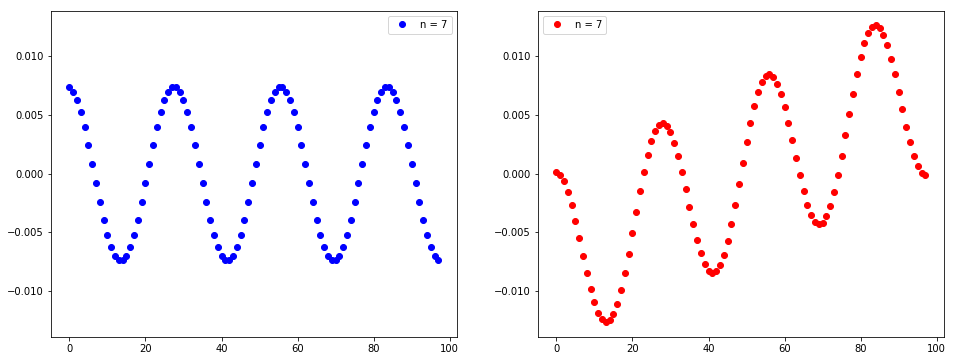

In [9]:
frequency, u, phi = piezo_homogeneous(c, rho, e, eps, x)

#mode number to plot
plot_ind = 7
plt.figure(figsize=(16,6))


custom_ylim = np.array([np.min((u[:,plot_ind:plot_ind+2], phi[:,plot_ind:plot_ind+2])), np.max((u[:,plot_ind:plot_ind+2], phi[:,plot_ind:plot_ind+2]))])

#displacement
plt.subplot(121)
plt.plot(u[:,plot_ind], "bo", label = f"n = {plot_ind}")
plt.ylim(custom_ylim * 1.1)
plt.legend()

#potential
plt.subplot(122)
plt.plot(phi[:,plot_ind], "ro", label = f"n = {plot_ind}")
plt.ylim(custom_ylim * 1.1)
plt.legend()


plt.show()

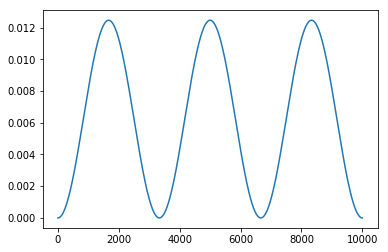

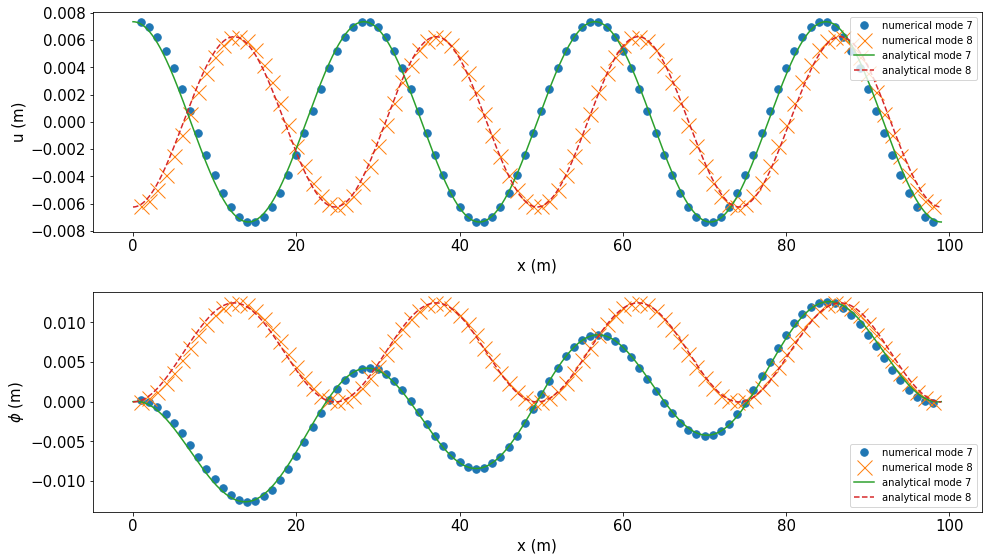

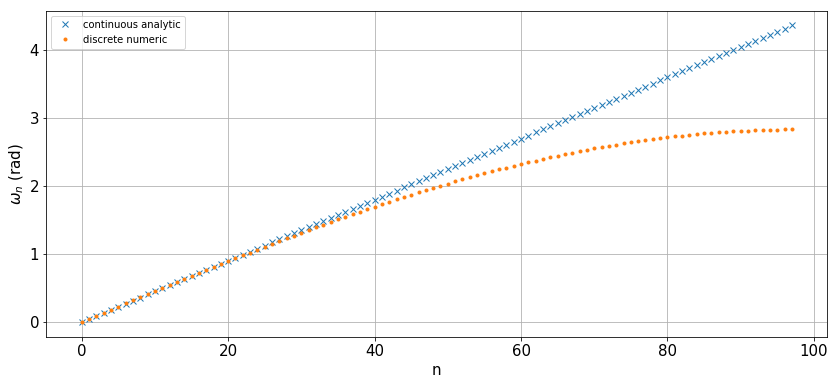

In [24]:
#analytical solution
A = np.max(u, axis = 0) * np.sign(u[0])
n = np.arange(0, N-2)
x_ana = np.linspace(x[0], x[-1], N*100)

#analytical phi
k = len(x_ana); l = len(u)
u_ana = np.zeros((k, l))
phi_ana = u_ana.copy()
for i in range(l):
    u_ana[:,i] = A[i]*np.cos(n[i]* np.pi/(x[-1]-x[0])*x_ana)
    phi_ana[:,i] = e / eps * (u_ana[:,i] + (u[0, i] - u[-1,i]) / (x[-1] - x[0]) * x_ana - u[0,i] )

    

        
plt.plot(phi_ana[:,6])
#analytic frequency calculation
k = np.arange(0,N+1,1) 
frequency_analytic = n * np.pi / (x1-x0) * np.sqrt((c + e**2/eps)/rho) 
frequency_analytic_hom = n * np.pi / (x1-x0) * np.sqrt((c)/rho) 

fs = 15

#plot an eigenmodes
ind = 7
fig = plt.figure(figsize=(14,8))
plt.subplot(211)
plt.plot(x[1:-1], u[:,ind], marker = '.', ls = "none", label = f"numerical mode {ind}", markersize = 15)
plt.plot(x[1:-1], u[:,ind+1], marker = 'x', ls = "none", label = f"numerical mode {ind+1}", markersize = 15)
plt.plot(x_ana,u_ana[:,ind], label = f"analytical mode {ind}") 
plt.plot(x_ana,u_ana[:,ind+1], label = f"analytical mode {ind+1}", ls = "--") 
plt.xlabel("x (m)", size = fs)
plt.ylabel("u (m)", size = fs)
plt.xticks(size = fs)
plt.yticks(size = fs)
plt.legend()

plt.subplot(212)
plt.plot(x[1:-1], phi[:,ind], marker = '.', ls = "none", label = f"numerical mode {ind}", markersize = 15)
plt.plot(x[1:-1], phi[:,ind+1], marker = 'x', ls = "none", label = f"numerical mode {ind+1}", markersize = 15)
plt.plot(x_ana,phi_ana[:,ind], label = f"analytical mode {ind}") 
plt.plot(x_ana,phi_ana[:,ind+1], label = f"analytical mode {ind+1}", ls = "--") 
plt.xlabel("x (m)", size = fs)
plt.ylabel("$\phi$ (m)", size = fs)
plt.legend()
plt.xticks(size = fs)
plt.yticks(size = fs)
plt.tight_layout(pad = 1.5)
plt.savefig("hom_piezo_modes.pdf",transparent = True, edgecolor = "white")
plt.show()

#plot eigenfrequencies
fig = plt.figure(figsize=(14,6))
plt.xlabel("n", size = fs)
plt.ylabel("$\omega_n$ (rad)", size = fs)
plt.plot(n, frequency_analytic, ls = "none", marker = "x", label = "continuous analytic")
#plt.plot(n, frequency_analytic_hom, ls = "none", marker = "+", label = "continuous acoustic")
plt.plot(n, frequency, ls = "none",marker = ".", label = "discrete numeric")
plt.xticks(size = fs)
plt.yticks(size = fs)
plt.legend()
plt.grid()
plt.savefig("hom_piezo_dispersion.pdf",transparent = True, edgecolor = "white")
plt.show()

Varying e

In [ ]:
e = [1,4,20]

us = []
phis = []

for i in range(len(e)):
    freqs, u, phi = piezo_homogeneous(c, rho, e[i], eps, x)
    us.append(u)
    phis.append(phi)

ind = 6

plt.figure(figsize=(14,9))
markers = itertools.cycle(['.','x','+'])
plt.subplot(2,1,1)
for i in range(len(e)):
    plt.plot(x[1:-1], us[i][:,ind], label = f"e = {e[i]}", ls = "none", marker = next(markers))
plt.legend()

plt.subplot(212)
for i in range(len(e)):
    plt.plot(x[1:-1], phis[i][:,ind], label = f"e = {e[i]}", ls = "none", marker = next(markers))
plt.legend()
plt.savefig("piezo_hom_influence_e.pdf")
plt.show()



# Analysis

* This is completely equivalent to the acoustic case, only a difference by a constant in the frequency. Same behaviour
    * What can we look into to discuss this more than just saying, it is the same apart from a constant?
        * We can try to explain how the electromechanical coupling induces this change in stifness/velocity..
        * What is the physics behind it?
            * Electric energy is converted to acoustic energy. More energy = higher frequency, same wavelength -> higher velocity
            
            
     

In [ ]:
a = np.array([[1,2,3],
              [4,5,6],
              [7,8,9]
             ])

norm = np.sum(a,axis = 0)

print(a / norm)